In [ ]:
%matplotlib inline

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:19<00:00, 8.93MB/s]


plane   dog  deer truck


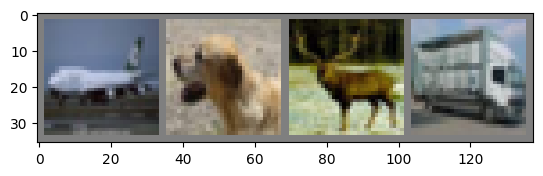

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(3, 64, kernel_size=5, padding=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=5, padding=2)

        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(128, 224, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(128, 224, kernel_size=5, padding=2)

        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv7 = nn.Conv2d(224, 448, kernel_size=5, padding=2)

        self.conv8 = nn.Conv2d(224, 224, kernel_size=5, padding=2)

        self.conv9 = nn.Conv2d(448, 224, kernel_size=5, padding=2)
        self.conv10 = nn.Conv2d(224, 448, kernel_size=5, padding=2)

        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv_dotted = nn.Conv2d(448, 256, kernel_size=5, padding=2)

        self.conv11 = nn.Conv2d(256, 256, kernel_size=5, padding=2)

        self.pool4 = nn.MaxPool2d(2, 2)

        self.conv_final = nn.Conv2d(256, 256, kernel_size=5, padding=2)

        self.fc = nn.Linear(256 * 4 * 4, num_classes)

        self.bn64 = nn.BatchNorm2d(64)
        self.bn128 = nn.BatchNorm2d(128)
        self.bn224 = nn.BatchNorm2d(224)
        self.bn448 = nn.BatchNorm2d(448)
        self.bn256 = nn.BatchNorm2d(256)
        self.bn128_final = nn.BatchNorm2d(128)

    def forward(self, x):
        x1 = F.relu(self.bn64(self.conv1(x)))
        x3 = F.relu(self.bn128(self.conv3(x1)))
        x3_pool = self.pool1(x3)

        x2 = F.relu(self.bn64(self.conv2(x)))

        x_cat1 = torch.cat([x1, x2], dim=1)
        x4 = F.relu(self.bn128(self.conv4(x_cat1)))
        x6 = F.relu(self.bn224(self.conv6(x4)))
        x6_pool = self.pool2(x6)

        x5 = F.relu(self.bn224(self.conv5(x3_pool)))
        x7 = F.relu(self.bn448(self.conv7(x5)))

        x_cat2 = torch.cat([x5, x6_pool], dim=1)
        x_add1 = x7 + x_cat2

        x8 = F.relu(self.bn224(self.conv8(x6_pool)))
        x9 = F.relu(self.bn224(self.conv9(x_add1)))
        x10 = F.relu(self.bn448(self.conv10(x9)))

        x_cat3 = torch.cat([x8, x9], dim=1)
        x_add2 = x_cat3 + x10

        out = self.pool3(x_add2)

        out = F.relu(self.bn256(self.conv_dotted(out)))

        out = F.relu(self.bn256(self.conv11(out)))
        out = self.pool4(out)

        out = F.relu(self.bn256(self.conv_final(out)))

        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

net = Net()
from torchsummary import summary
net = net.to(device)
summary(net, (3, 32, 32))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 32, 32]         204,928
       BatchNorm2d-4          [-1, 128, 32, 32]             256
         MaxPool2d-5          [-1, 128, 16, 16]               0
            Conv2d-6           [-1, 64, 32, 32]           4,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
            Conv2d-8          [-1, 128, 32, 32]         409,728
       BatchNorm2d-9          [-1, 128, 32, 32]             256
           Conv2d-10          [-1, 224, 32, 32]         717,024
      BatchNorm2d-11          [-1, 224, 32, 32]             448
        MaxPool2d-12          [-1, 224, 16, 16]               0
           Conv2d-13          [-1, 224, 16, 16]         717,024
      BatchNorm2d-14          [-

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.273
[1,  4000] loss: 1.744
[1,  6000] loss: 1.525
[1,  8000] loss: 1.368
[1, 10000] loss: 1.218
[1, 12000] loss: 1.111
[2,  2000] loss: 1.025
[2,  4000] loss: 0.957
[2,  6000] loss: 0.906
[2,  8000] loss: 0.867
[2, 10000] loss: 0.844
[2, 12000] loss: 0.797
[3,  2000] loss: 0.709
[3,  4000] loss: 0.696
[3,  6000] loss: 0.667
[3,  8000] loss: 0.639
[3, 10000] loss: 0.653
[3, 12000] loss: 0.634
[4,  2000] loss: 0.527
[4,  4000] loss: 0.523
[4,  6000] loss: 0.513
[4,  8000] loss: 0.519
[4, 10000] loss: 0.514
[4, 12000] loss: 0.496
[5,  2000] loss: 0.380
[5,  4000] loss: 0.397
[5,  6000] loss: 0.411
[5,  8000] loss: 0.412
[5, 10000] loss: 0.395
[5, 12000] loss: 0.403
[6,  2000] loss: 0.277
[6,  4000] loss: 0.297
[6,  6000] loss: 0.304
[6,  8000] loss: 0.304
[6, 10000] loss: 0.319
[6, 12000] loss: 0.311
[7,  2000] loss: 0.194
[7,  4000] loss: 0.213
[7,  6000] loss: 0.223
[7,  8000] loss: 0.250
[7, 10000] loss: 0.227
[7, 12000] loss: 0.227
[8,  2000] loss: 0.130
[8,  4000] 

GroundTruth:    cat  ship  ship plane


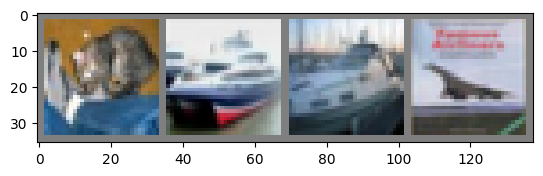

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
images, labels = data[0].to(device), data[1].to(device)
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog horse  ship  frog


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 83 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 83 %
Accuracy of   car : 91 %
Accuracy of  bird : 79 %
Accuracy of   cat : 60 %
Accuracy of  deer : 83 %
Accuracy of   dog : 79 %
Accuracy of  frog : 90 %
Accuracy of horse : 85 %
Accuracy of  ship : 85 %
Accuracy of truck : 91 %
